##### Copyright 2019 The TensorFlow Authors.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Set up the input pipeline

Install the [tensorflow_examples](https://github.com/tensorflow/examples) package that enables importing of the generator and the discriminator.

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-m1q38tdm
  Created wheel for tensorflow-examples: filename=tensorflow_examples-56524742e739278cc52e2fcfc978e81d64cfcbd3_-py3-none-any.whl size=268469 sha256=45242c3970221d169bd34a14642962c310818fe08d7d1b083b802763cf2effbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-477pcj3r/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Successfully built tensorflow-examples
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf

In [3]:
#import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [4]:
def ensure_directory(*args):
    dir = os.path.join(*args)
    try:
        os.makedirs(dir)
    except OSError as err:
        if err.errno != 17:
            raise err
    return dir

In [5]:
project_dir = os.path.abspath("_projects/madina")
train_dir = os.path.join(project_dir, "input/faces_256/train")
train_female_dir = os.path.join(train_dir, "female")
train_male_dir = os.path.join(train_dir, "male")
test_dir = os.path.join(project_dir, "input/faces_256/test")
test_female_dir = os.path.join(test_dir, "female")
test_male_dir = os.path.join(test_dir, "male")
output_dir = ensure_directory(project_dir, "output/v002")
model_dir = output_dir
checkpoint_dir = ensure_directory(output_dir, "checkpoints")
log_dir = ensure_directory(output_dir, "log")
output_image_dir = ensure_directory(output_dir, "images")
glob_pattern = '*.jpg'
print(project_dir)

/tf/_projects/madina


In [6]:
sample_image_filename = glob.glob(os.path.join(train_female_dir, glob_pattern))[0]
print(sample_image_filename)
sample_image = tf.io.read_file(sample_image_filename)
sample_image = tf.io.decode_png(sample_image)
print(sample_image.shape)

/tf/_projects/madina/input/faces_256/train/female/08030.jpg
(256, 256, 3)


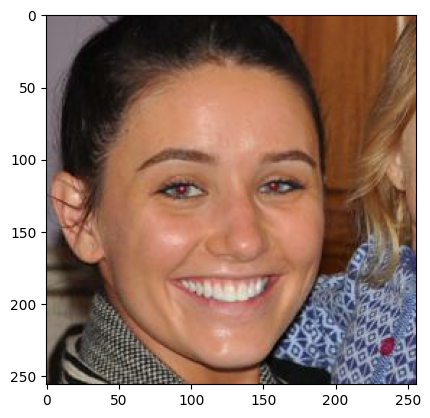

In [7]:
plt.figure()
plt.imshow(sample_image)
plt.show()

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
#@tf.autograph.experimental.do_not_convert
def load_image(fname):
    print('load_image', fname)
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(fname)
    image = tf.io.decode_png(image)
    return image

In [10]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [11]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [12]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [13]:
def preprocess_image_train(fname):
  print('Filename:', fname)
  image = load_image(fname)
  image = random_jitter(image)
  image = normalize(image)
  return image

In [14]:
def preprocess_image_test(fname):
  image = load_image(fname)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  image = normalize(image)
  return image

In [15]:

train_female = tf.data.Dataset.list_files(os.path.join(train_female_dir, glob_pattern))
train_female = train_female.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_female = train_female.shuffle(BUFFER_SIZE)
train_female = train_female.batch(BATCH_SIZE)


train_male = tf.data.Dataset.list_files(os.path.join(train_male_dir, glob_pattern))
train_male = train_male.map(preprocess_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_male = train_male.shuffle(BUFFER_SIZE)
train_male = train_male.batch(BATCH_SIZE)

test_female = tf.data.Dataset.list_files(os.path.join(test_female_dir, glob_pattern))
test_female = test_female.map(preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_female = test_female.shuffle(BUFFER_SIZE)
test_female = test_female.batch(BATCH_SIZE)

test_male = tf.data.Dataset.list_files(os.path.join(test_male_dir, glob_pattern))
test_male = test_male.map(preprocess_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_male = test_male.shuffle(BUFFER_SIZE)
test_male = test_male.batch(BATCH_SIZE)

Filename: Tensor("args_0:0", shape=(), dtype=string)
load_image Tensor("args_0:0", shape=(), dtype=string)
Filename: Tensor("args_0:0", shape=(), dtype=string)
load_image Tensor("args_0:0", shape=(), dtype=string)
load_image Tensor("args_0:0", shape=(), dtype=string)
load_image Tensor("args_0:0", shape=(), dtype=string)


(16, 256, 256, 3)


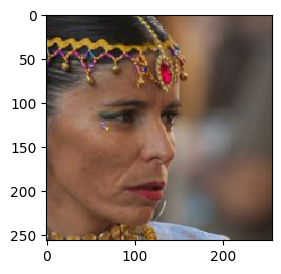

In [16]:
sample_female_image = list(train_female.take(1))[0]
print(sample_female_image.shape)
fig = plt.figure()
fig.add_subplot(1, 2, 1).imshow(sample_female_image[0] * 0.5 + 0.5)
#fig.add_subplot(1, 2, 2).imshow(sample_real_batch[0]  * 0.5 + 0.5)
plt.show()

In [17]:
sample_female = next(iter(train_female))
sample_male = next(iter(train_male))

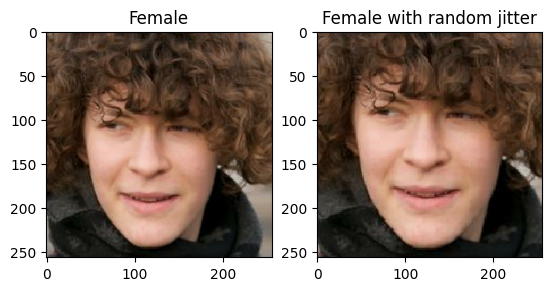

In [18]:
plt.subplot(121)
plt.title('Female')
plt.imshow(sample_female[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Female with random jitter')
plt.imshow(random_jitter(sample_female[0]) * 0.5 + 0.5)
plt.show()

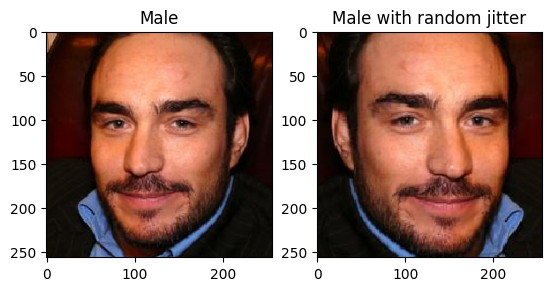

In [19]:
plt.subplot(121)
plt.title('Male')
plt.imshow(sample_male[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Male with random jitter')
plt.imshow(random_jitter(sample_male[0]) * 0.5 + 0.5)
plt.show()

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

The model architecture used in this tutorial is very similar to what was used in [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). Some of the differences are:

* Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).
* The [CycleGAN paper](https://arxiv.org/abs/1703.10593) uses a modified `resnet` based generator. This tutorial is using a modified `unet` generator for simplicity.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [20]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


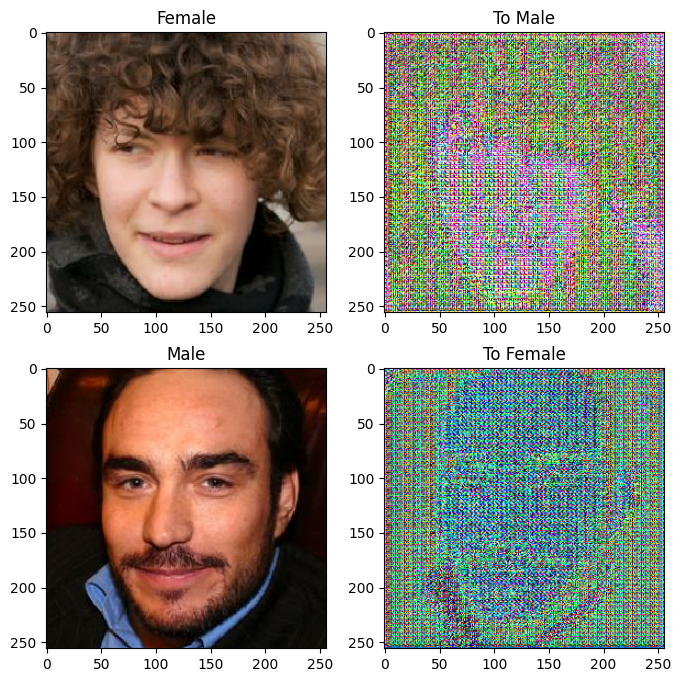

In [21]:
to_male = generator_g(sample_female)
to_female = generator_f(sample_male)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_female, to_male, sample_male, to_female]
title = ['Female', 'To Male', 'Male', 'To Female']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

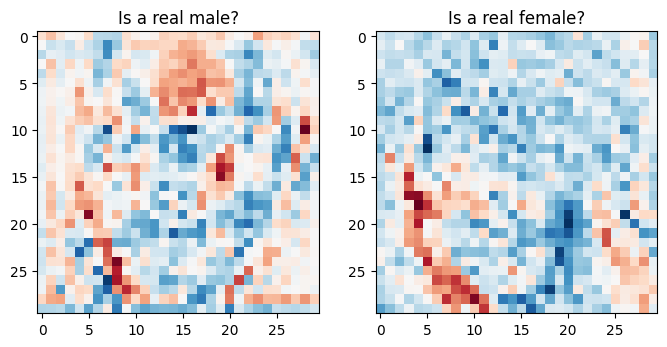

In [22]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real male?')
plt.imshow(discriminator_y(sample_male)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real female?')
plt.imshow(discriminator_x(sample_female)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [23]:
LAMBDA = 10

In [24]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [26]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [48]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(real_image - cycled_image)
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [49]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.2 * loss

Initialize the optimizers for all the generators and the discriminators.

In [50]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [51]:
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=None)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [52]:
EPOCHS = 4000

In [53]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [54]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

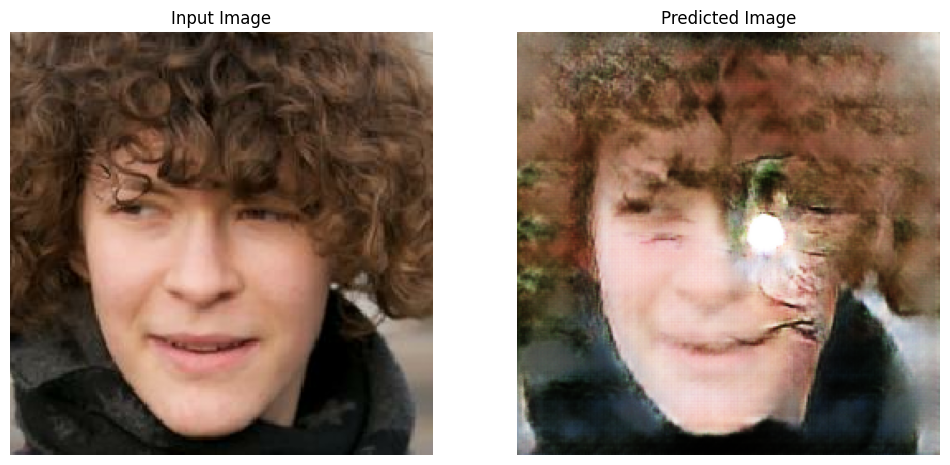

Saving checkpoint for epoch 10 at /tf/_projects/madina/output/v002/checkpoints/ckpt-5
Time taken for epoch 10 is 127.64072918891907 sec

.

KeyboardInterrupt: 

In [55]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_female, train_male)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_female)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

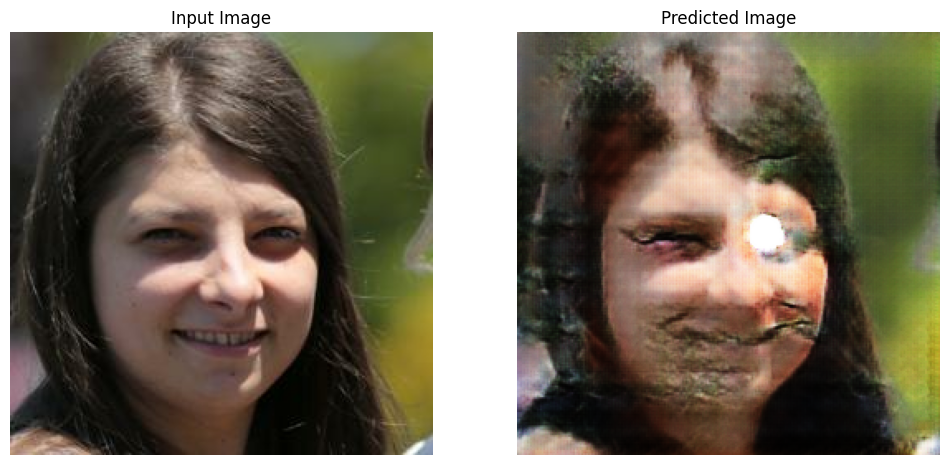

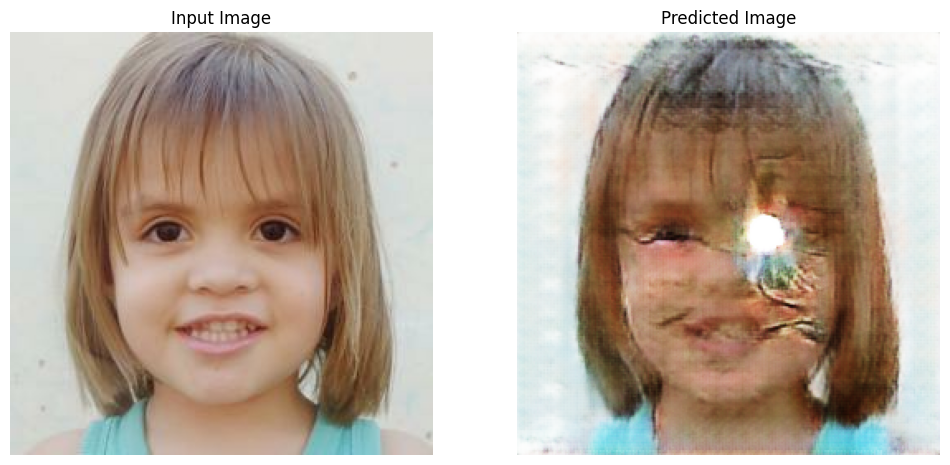

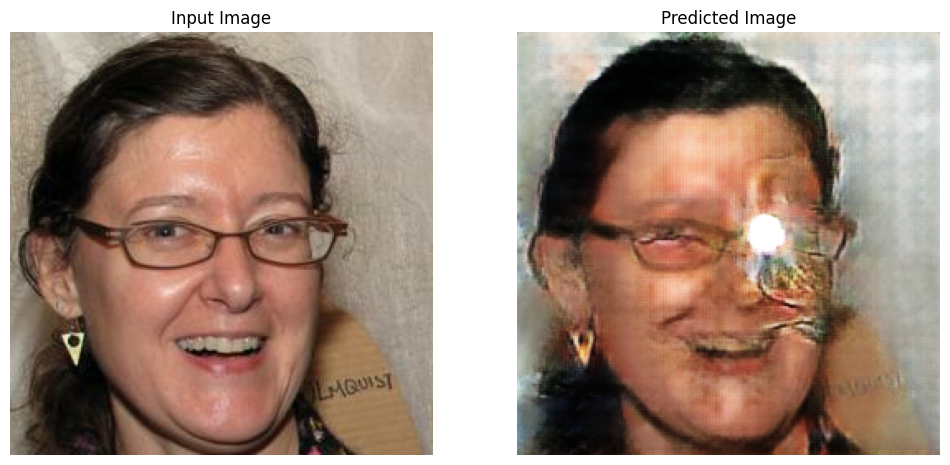

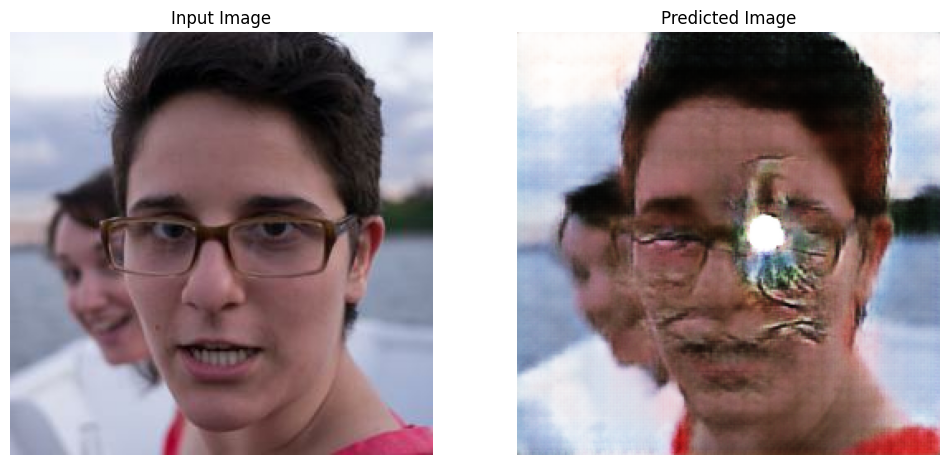

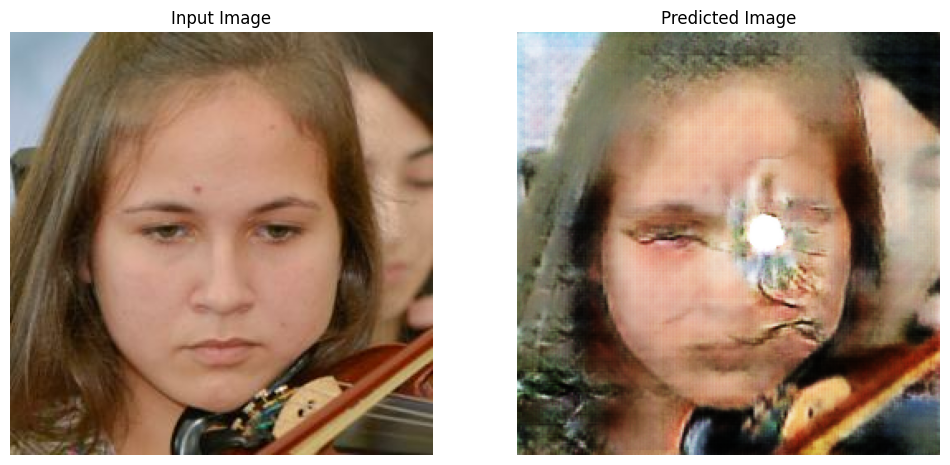

In [56]:
# Run the trained model on the test dataset
for inp in test_female.take(5):
  generate_images(generator_g, inp)

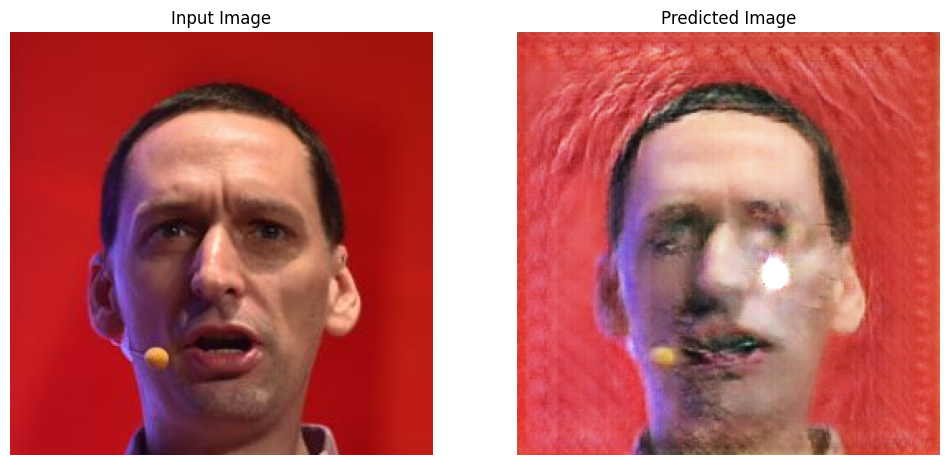

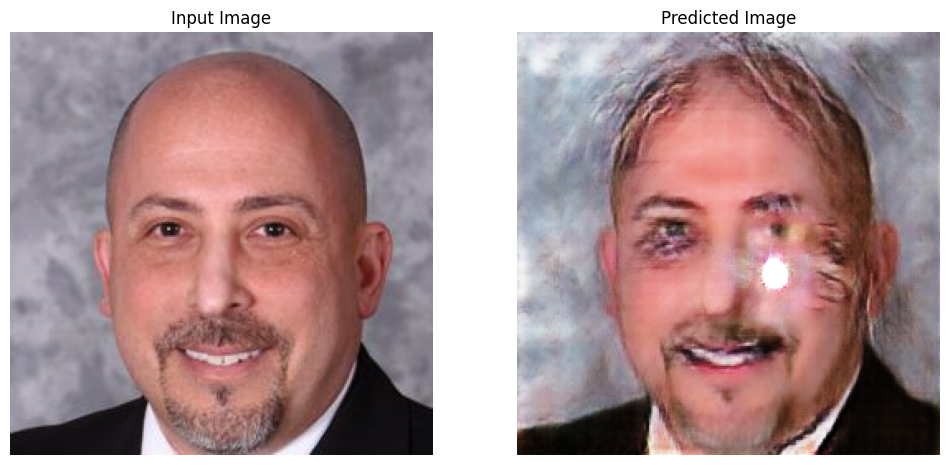

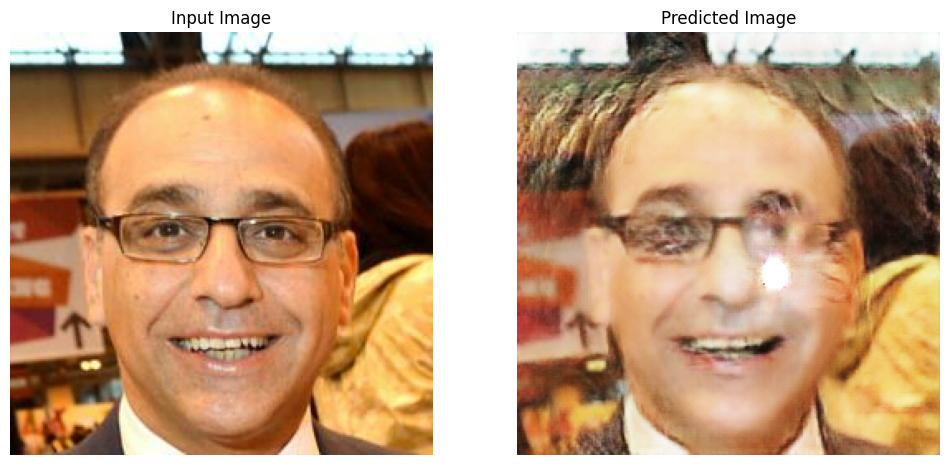

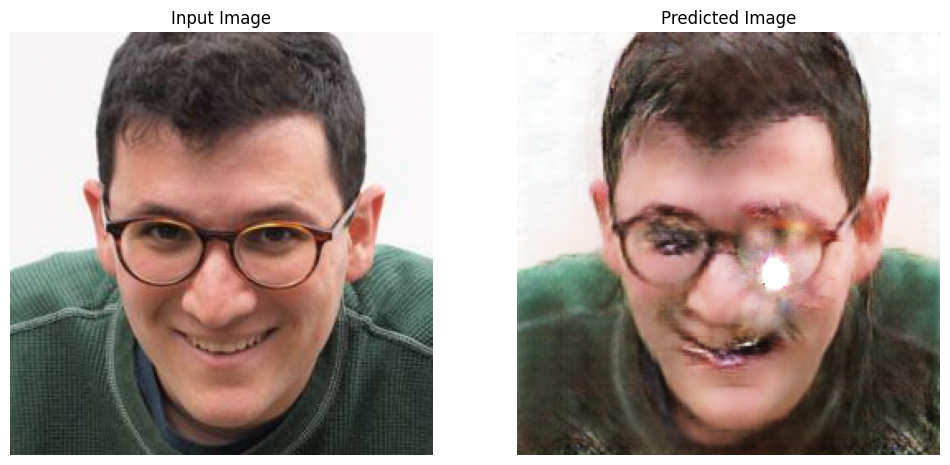

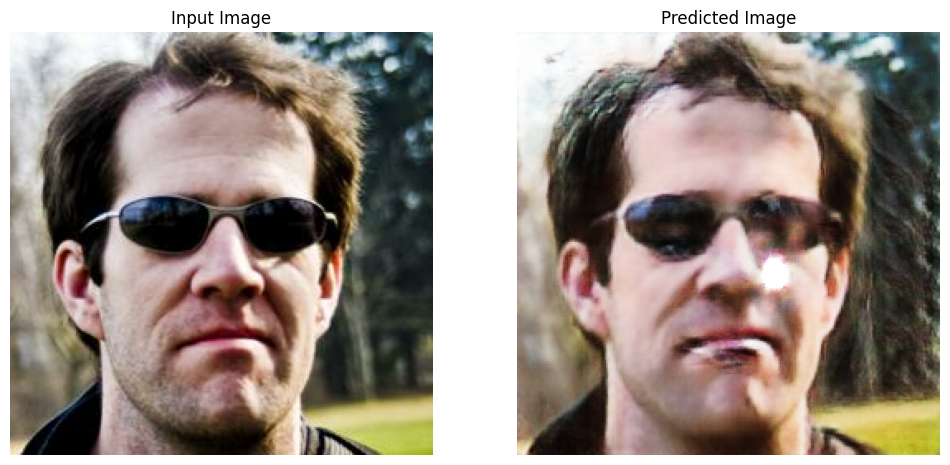

In [57]:
for inp in test_male.take(5):
  generate_images(generator_f, inp)

In [58]:
generator_g.save(os.path.join(model_dir, 'generator_female_to_male'))
generator_f.save(os.path.join(model_dir, 'generator_male_to_female'))

INFO:tensorflow:Assets written to: /tf/_projects/madina/output/v001/generator_female_to_male/assets
INFO:tensorflow:Assets written to: /tf/_projects/madina/output/v001/generator_male_to_female/assets


## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.